# Using continous and categorical only from transition matrices the category was obtained to filter data by category, but transition matrices data was not involved in euclidean distance.

In [1222]:
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt 
import math
from ipynb.fs.full.Utils import createKDeplot, loadDataFrames, dropFeaturesWithNoVariance, loadCoverGroups
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
import dask_ml.cluster
from ipynb.fs.full.Pipeline import removeConstantFeatures, applyBoxCoxAllFeatures, centerAndScale, applyEuclideanDistance, getIndexAndVector, applyBoxCoxFeatures,applyJaccard, getEuclideanJaccardDf , euclidean_distance

In [1223]:
covers = loadCoverGroups()
originalSongId = covers[0][0]
coverSongId = covers[0][2]

In [1224]:
originalSongId

180849

In [1225]:
coverSongId

1686718

In [1226]:
coverSongId

1686718

In [1227]:
transitionMatrices = pd.read_csv('./data/unified/07-transitionsClustered.csv')
transitionMatrices = transitionMatrices[['id','category']]

In [1228]:
df = pd.read_csv("./data/unified/05-allDataContinousCategoricalTransition.csv")
df = df.drop(columns=['Unnamed: 0', 'index'])

In [1229]:
df = pd.merge(df,transitionMatrices, on='id')

In [1230]:
categoryOriginalSong = df[df.id == originalSongId].category.values[0]
df = df[df.category == categoryOriginalSong]
df = df.drop(columns=['category'])

In [1231]:
## Removing unamed and other unnecessary columns
df.reset_index(drop=True, inplace=True)
df = df.sort_values('id')
df.id = df.id.astype('int64')
# Saving idChords
ids = df.id
df = df.set_index('id')
df.reset_index(drop=True, inplace=True)

In [1232]:
df

,danceability,energy,speechiness,acousticness,liveness,valence,tempo,0,1,2,...,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11,instrumentalness_cat_0,instrumentalness_cat_1,instrumentalness_cat_2
0,0.582,0.744,0.0336,0.000458,0.0405,0.674,133.344,0.185185,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.577,0.890,0.0345,0.000013,0.0954,0.643,132.397,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.664,0.787,0.0239,0.038000,0.1930,0.585,102.952,0.007634,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.726,0.537,0.1140,0.316000,0.0707,0.882,96.889,0.101351,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.550,0.145,0.0332,0.913000,0.1180,0.138,103.918,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,0.700,0.710,0.0532,0.327000,0.1290,0.582,167.971,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2166,0.760,0.838,0.0510,0.390000,0.1660,0.863,159.938,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2167,0.665,0.515,0.0442,0.454000,0.3670,0.805,93.082,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2168,0.555,0.578,0.0277,0.113000,0.0747,0.333,83.382,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1233]:
df

,danceability,energy,speechiness,acousticness,liveness,valence,tempo,0,1,2,...,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11,instrumentalness_cat_0,instrumentalness_cat_1,instrumentalness_cat_2
0,0.582,0.744,0.0336,0.000458,0.0405,0.674,133.344,0.185185,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.577,0.890,0.0345,0.000013,0.0954,0.643,132.397,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.664,0.787,0.0239,0.038000,0.1930,0.585,102.952,0.007634,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.726,0.537,0.1140,0.316000,0.0707,0.882,96.889,0.101351,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.550,0.145,0.0332,0.913000,0.1180,0.138,103.918,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,0.700,0.710,0.0532,0.327000,0.1290,0.582,167.971,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2166,0.760,0.838,0.0510,0.390000,0.1660,0.863,159.938,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2167,0.665,0.515,0.0442,0.454000,0.3670,0.805,93.082,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2168,0.555,0.578,0.0277,0.113000,0.0747,0.333,83.382,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1234]:
continousFeatures, categoricalFeatures = getEuclideanJaccardDf(df)

In [1235]:
categoricalFeatures

,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,...,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11,instrumentalness_cat_0,instrumentalness_cat_1,instrumentalness_cat_2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2166,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2167,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1236]:
continousFeatures = continousFeatures[['acousticness', 'danceability', 'energy', 'liveness', 'speechiness', 'tempo', 'valence']]

In [1237]:
continousFeatures.energy.max()

0.991

In [1238]:
continousFeatures.energy.min()

0.0231

<AxesSubplot:>

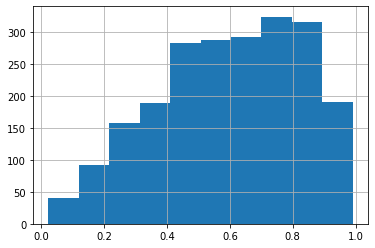

In [1239]:
continousFeatures.energy.hist()

In [1240]:
continousFeatures

,acousticness,danceability,energy,liveness,speechiness,tempo,valence
0,0.000458,0.582,0.744,0.0405,0.0336,133.344,0.674
1,0.000013,0.577,0.890,0.0954,0.0345,132.397,0.643
2,0.038000,0.664,0.787,0.1930,0.0239,102.952,0.585
3,0.316000,0.726,0.537,0.0707,0.1140,96.889,0.882
4,0.913000,0.550,0.145,0.1180,0.0332,103.918,0.138
...,...,...,...,...,...,...,...
2165,0.327000,0.700,0.710,0.1290,0.0532,167.971,0.582
2166,0.390000,0.760,0.838,0.1660,0.0510,159.938,0.863
2167,0.454000,0.665,0.515,0.3670,0.0442,93.082,0.805
2168,0.113000,0.555,0.578,0.0747,0.0277,83.382,0.333


In [1241]:
originalSongIndex,originalSongVector = getIndexAndVector(originalSongId, ids, continousFeatures)
coverSongIndex,coverSongVector = getIndexAndVector(coverSongId, ids, continousFeatures)

In [1242]:
coverSongVector

acousticness      0.7220
danceability      0.3340
energy            0.2520
liveness          0.0907
speechiness       0.0287
tempo           153.8790
valence           0.2140
Name: 1327, dtype: float64

In [1243]:
euclidean_distance(originalSongVector,coverSongVector)

7.607674207666891

In [1244]:
continousFeatures.tempo.describe()

count    2170.000000
mean      121.782344
std        30.242297
min        48.718000
25%        96.246250
50%       120.883500
75%       142.062250
max       207.604000
Name: tempo, dtype: float64

In [1245]:
# tempoDF = continousFeatures.tempo.copy()
# tempoDF = pd.DataFrame(tempoDF)
# scaler = MinMaxScaler()
# scaler.fit(tempoDF)
# continousFeatures.tempo = pd.DataFrame(scaler.transform(tempoDF)).iloc[:,0]

In [1246]:
# tempoDF

In [1247]:
continousFeatures = removeConstantFeatures(continousFeatures)
continousFeatures= applyBoxCoxAllFeatures(continousFeatures)
continousFeatures = centerAndScale(continousFeatures)

mean:  [-0. -0. -0. -0. -0.  0.  0.]
std:  [1. 1. 1. 1. 1. 1. 1.]


In [1248]:
continousFeatures.tempo.describe()

count    2.170000e+03
mean     2.292073e-17
std      1.000230e+00
min     -3.034699e+00
25%     -8.232910e-01
50%      4.965329e-02
75%      7.134905e-01
max      2.436110e+00
Name: tempo, dtype: float64

In [1249]:
continousFeatures.describe()

,acousticness,danceability,energy,liveness,speechiness,tempo,valence
count,2.170000e+03,2.170000e+03,2.170000e+03,2.170000e+03,2.170000e+03,2.170000e+03,2.170000e+03
mean,-7.940397e-17,-1.178781e-16,-5.239025e-17,-1.702683e-16,-2.488537e-16,2.292073e-17,5.239025e-17
std,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00,1.000230e+00
min,-1.231499e+00,-2.756418e+00,-2.200203e+00,-3.049993e+00,-1.591135e+00,-3.034699e+00,-2.142509e+00
25%,-1.001181e+00,-7.097474e-01,-7.813242e-01,-6.990690e-01,-7.988958e-01,-8.232910e-01,-7.851085e-01
50%,-1.620813e-01,-1.212040e-02,1.267694e-02,-3.133353e-01,-2.735741e-01,4.965329e-02,-3.229167e-02
75%,1.000823e+00,7.168190e-01,8.323756e-01,7.952590e-01,6.987341e-01,7.134905e-01,8.303918e-01
max,1.641970e+00,2.697203e+00,1.925975e+00,2.004746e+00,2.168233e+00,2.436110e+00,1.894704e+00


In [1250]:
# Scaling -> MinMax
# Normalization -> 0-1
# Normally Distributed Data 

### Original Song & Cover Song

In [1251]:
originalSongIndex,originalSongVector = getIndexAndVector(originalSongId, ids, continousFeatures)
coverSongIndex,coverSongVector = getIndexAndVector(coverSongId, ids, continousFeatures)

### Get Rankings Euclidean

In [1252]:
a = continousFeatures.iloc[[originalSongIndex,coverSongIndex], : ].copy()

In [1253]:
a 

,acousticness,danceability,energy,liveness,speechiness,tempo,valence
296,1.332226,0.086610,-0.737620,-0.457708,-1.452829,0.837951,-1.083189
1327,1.319001,-1.404262,-1.462193,-0.802569,-0.989022,1.056795,-1.077806


In [1254]:
a['id'] = a.index.tolist()

In [1255]:
a

,acousticness,danceability,energy,liveness,speechiness,tempo,valence,id
296,1.332226,0.086610,-0.737620,-0.457708,-1.452829,0.837951,-1.083189,296
1327,1.319001,-1.404262,-1.462193,-0.802569,-0.989022,1.056795,-1.077806,1327


In [1256]:
a.reset_index(drop=True, inplace=True)

In [1257]:
a

,acousticness,danceability,energy,liveness,speechiness,tempo,valence,id
0,1.332226,0.086610,-0.737620,-0.457708,-1.452829,0.837951,-1.083189,296
1,1.319001,-1.404262,-1.462193,-0.802569,-0.989022,1.056795,-1.077806,1327


In [1258]:
ids2 = a['id']

In [1259]:
ids2

0     296
1    1327
Name: id, dtype: int64

In [1260]:
a = a.drop('id', axis=1)

In [1261]:
a

,acousticness,danceability,energy,liveness,speechiness,tempo,valence
0,1.332226,0.086610,-0.737620,-0.457708,-1.452829,0.837951,-1.083189
1,1.319001,-1.404262,-1.462193,-0.802569,-0.989022,1.056795,-1.077806


In [1262]:
euclidean_distance(originalSongVector, continousFeatures.iloc[940,:])

3.4606326215386463

In [1263]:
euclidean_distance( coverSongVector, originalSongVector)

1.7691372284462332

In [1264]:
originalSongVector

acousticness    1.332226
danceability    0.086610
energy         -0.737620
liveness       -0.457708
speechiness    -1.452829
tempo           0.837951
valence        -1.083189
Name: 296, dtype: float64

In [1265]:
ids2[0]

296

In [1266]:
originalSongId

180849

In [1267]:
coverSongId

1686718

In [1268]:
applyEuclideanDistance(a, ids2, originalSongVector)


distance


,id,rank
0,296,0.000000
1,1327,1.769137


In [1293]:
categoricalFeatures

,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,...,mood_5,mood_6,mood_7,mood_8,mood_9,mood_10,mood_11,instrumentalness_cat_0,instrumentalness_cat_1,instrumentalness_cat_2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2166,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2167,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1269]:
ranksDFEuclidean  = applyEuclideanDistance(continousFeatures, ids, originalSongVector)
ranksDFEuclidean

distance


,id,rank
0,6001027,0.000000
1,180849,0.000000
2,1874688,0.559494
3,1680532,0.733879
4,188071,0.752317
...,...,...
2165,6001526,6.019329
2166,6001749,6.019915
2167,872966,6.024660
2168,773254,6.098996


In [1270]:
ranksDFEuclidean[ranksDFEuclidean['id'] == originalSongId]

,id,rank
1,180849,0.0


In [1271]:
ranksDFEuclidean[ranksDFEuclidean['id'] == coverSongId]

,id,rank
137,1686718,1.769137


In [1272]:
continousFeatures

,acousticness,danceability,energy,liveness,speechiness,tempo,valence
0,-1.227977,0.257396,0.622879,-1.983663,-0.543944,0.448391,0.929549
1,-1.231443,0.223182,1.372440,-0.713854,-0.469501,0.418939,0.817621
2,-0.951834,0.822468,0.837424,0.572114,-1.498338,-0.572863,0.600774
3,0.403437,1.254573,-0.337272,-1.218229,1.921044,-0.798817,1.617744
4,1.560283,0.038917,-1.825540,-0.328899,-0.577721,-0.537647,-1.503871
...,...,...,...,...,...,...,...
2165,0.440012,1.072868,0.456913,-0.163927,0.680782,1.444954,0.589283
2166,0.632751,1.493262,1.098613,0.302351,0.577924,1.226346,1.559004
2167,0.803037,0.829405,-0.432241,1.501219,0.211083,-0.945307,1.374847
2168,-0.482831,0.072978,-0.156656,-1.129851,-1.088754,-1.336566,-0.474934


In [1273]:
ranksDFEuclidean[ranksDFEuclidean.id == originalSongId]

,id,rank
1,180849,0.0


In [1274]:
ranksDFEuclidean[ranksDFEuclidean['id']==coverSongId]

,id,rank
137,1686718,1.769137


In [1275]:
ranksDFEuclidean.loc[ranksDFEuclidean['id'].isin(covers[0])]

,id,rank
0,6001027,0.000000
1,180849,0.000000
41,5000008,1.269548
88,5000011,1.555545
137,1686718,1.769137
138,5000013,1.769137
243,5000017,2.055898
365,5000001,2.359942
427,5000007,2.494952
548,5000018,2.725559


### Get Rankings Jaccard

In [1276]:
originalSongIndex,originalSongVector = getIndexAndVector(originalSongId, ids, categoricalFeatures)
coverSongIndex,coverSongVector = getIndexAndVector(coverSongId, ids, categoricalFeatures)

In [1277]:
ranksDFJaccard  = applyJaccard(categoricalFeatures, ids, originalSongVector)

In [1278]:
ranksDFJaccard

,id,rank
0,180849,0.0
1,6001027,0.0
2,450492,0.0
3,466649,0.0
4,1029726,0.0
...,...,...
2165,780945,1.0
2166,388558,1.0
2167,821402,1.0
2168,6001417,1.0


In [1279]:
ranksDFJaccard[ranksDFJaccard['id']==coverSongId]

,id,rank
640,1686718,0.571429


In [1280]:
ranksDFJaccard.loc[ranksDFJaccard.id.isin(covers[0])]

,id,rank
0,180849,0.000000
1,6001027,0.000000
36,5000001,0.333333
37,5000017,0.333333
38,5000019,0.333333
40,5000020,0.333333
327,5000018,0.571429
330,5000013,0.571429
335,5000008,0.571429
640,1686718,0.571429


In [1281]:
ranksDFEuclidean

,id,rank
0,6001027,0.000000
1,180849,0.000000
2,1874688,0.559494
3,1680532,0.733879
4,188071,0.752317
...,...,...
2165,6001526,6.019329
2166,6001749,6.019915
2167,872966,6.024660
2168,773254,6.098996


In [1282]:
ranksDFJaccard

,id,rank
0,180849,0.0
1,6001027,0.0
2,450492,0.0
3,466649,0.0
4,1029726,0.0
...,...,...
2165,780945,1.0
2166,388558,1.0
2167,821402,1.0
2168,6001417,1.0


### Experiment to unify rangs

In [1283]:
ranks = pd.merge(ranksDFJaccard,ranksDFEuclidean, on='id')

In [1284]:
ranks[ranks['id']==coverSongId]

,id,rank_x,rank_y
640,1686718,0.571429,1.769137


In [1285]:
ranks['new_rank'] = ranks['rank_x'] + ranks['rank_y']

In [1286]:
ranks = ranks.sort_values(by='new_rank')
ranks.reset_index(drop=True, inplace=True)

In [1287]:
ranks.head(10)

,id,rank_x,rank_y,new_rank
0,180849,0.000000,0.000000,0.000000
1,6001027,0.000000,0.000000,0.000000
2,1680532,0.333333,0.733879,1.067212
3,1874688,0.571429,0.559494,1.130923
4,924053,0.333333,0.949537,1.282870
5,188071,0.571429,0.752317,1.323746
6,832936,0.571429,0.841199,1.412627
7,334542,0.333333,1.080454,1.413787
8,2065851,0.333333,1.081016,1.414350
9,1949223,0.571429,0.862944,1.434372


In [1289]:
ranks.loc[ranks.id.isin(covers[0])]

,id,rank_x,rank_y,new_rank
0,180849,0.000000,0.000000,0.000000
1,6001027,0.000000,0.000000,0.000000
35,5000008,0.571429,1.269548,1.840977
111,5000011,0.750000,1.555545,2.305545
119,1686718,0.571429,1.769137,2.340566
120,5000013,0.571429,1.769137,2.340566
136,5000017,0.333333,2.055898,2.389231
228,5000001,0.333333,2.359942,2.693275
470,5000007,0.750000,2.494952,3.244952
499,5000018,0.571429,2.725559,3.296987
